In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
import torch
import torch.nn as nn

In [83]:
# setup matplotlib params
plt.rcParams["font.family"] = "Times"
plt.rcParams["font.size"] = 15

In [5]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [35]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageEnhance
import glob

# create custom dataset class
class OCTDataset(Dataset):
	def __init__(self, data_dir, label=0):
		self.data_dir = data_dir
		# transform to tensor, increase contrast, normalize, resize to 224x224
		self.transform = transforms.Compose(
			[transforms.ToTensor(),
			 transforms.Resize((224, 224), antialias=None),
			 transforms.GaussianBlur(kernel_size=3, sigma=1),
			 transforms.Normalize(mean=[0.4, 0.4, 0.4], std=[0.5, 0.5, 0.5])])

		# list .png files in data_dir
		self.img_list = glob.glob(os.path.join(data_dir, '*'))
		self.label = label

	def __len__(self):
		return len(self.img_list)

	def __getitem__(self, idx):
		img_path = self.img_list[idx]
		is_OS = img_path.split('/')[-1].split('_')[1] == 'OS'
		imgs_pth = sorted(glob.glob(os.path.join(img_path, '*.png')))
		imgs = []

		for img in imgs_pth:
			img = Image.open(img).convert('L')
			img = ImageEnhance.Contrast(img).enhance(2)
			if is_OS:
				img = img.transpose(Image.FLIP_LEFT_RIGHT)
			imgs.append(np.array(img))

		img = np.stack(imgs, axis=-1)
		img = self.transform(img)
		return img, self.label

In [36]:
# load data
AD = OCTDataset(data_dir='../data_3D/3D_AD_OCT', label=1)
AD_normal = OCTDataset(data_dir='../data_3D/3D_AD_normal_OCT', label=0)
CVD_normal = OCTDataset(data_dir='../data_3D/3D_CVD_normal_OCT', label=0)

# discard CVD data to balance dataset
# CVD_normal = torch.utils.data.Subset(CVD_normal, range(0, len(AD)-len(AD_normal)))

# mix data to create one dataset
dataset = torch.utils.data.ConcatDataset([AD, AD_normal, CVD_normal])

In [37]:
print('Number of images in dataset: ', len(dataset))
print('Positive samples: ', len(AD))
print('Negative samples: ', len(AD_normal) + len(CVD_normal))

Number of images in dataset:  287
Positive samples:  133
Negative samples:  154


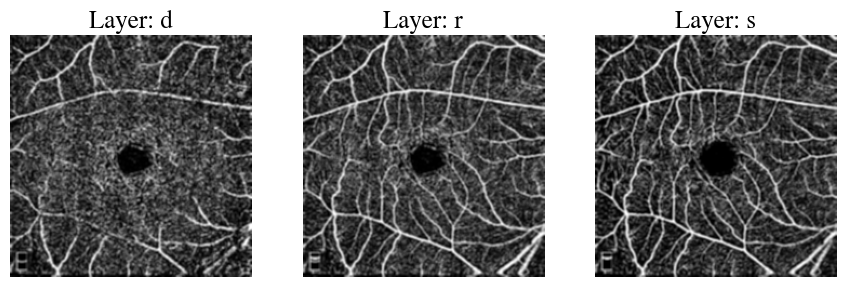

In [84]:
# show some images
fig = plt.figure(figsize=(9, 3))
labels = ['d', 'r', 's']
for i in range(3):
	img, label = dataset[1]
	ax = fig.add_subplot(1, 3, i+1)
	# show one channel of image
	ax.imshow(img[i], cmap='gray')
	ax.set_title('Layer: {}'.format(labels[i]))
	ax.axis('off')

# save image
plt.tight_layout()
plt.savefig('plots/data_layers.png', dpi=500)

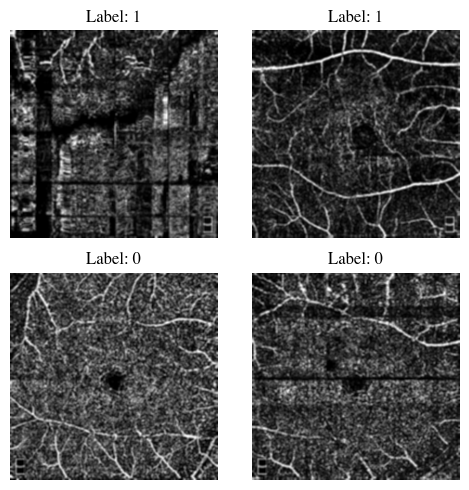

In [40]:
# show some images
fig = plt.figure(figsize=(5, 5))
for i in range(4):
	img, label = dataset[i * 71]
	ax = fig.add_subplot(2, 2, i+1)
	# show one channel of image
	ax.imshow(img[0], cmap='gray')
	ax.set_title('Label: {}'.format(label))
	ax.axis('off')

# save image
plt.tight_layout()
plt.savefig('plots/data.png', dpi=500)

In [41]:
# load pretrained resent models
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152

# create custom resnet model
class ResNet(nn.Module):
	def __init__(self, model_name):
		super(ResNet, self).__init__()
		if model_name == 'resnet18':
			self.model = resnet18(weights="IMAGENET1K_V1")
		elif model_name == 'resnet34':
			self.model = resnet34(weights="IMAGENET1K_V1")
		elif model_name == 'resnet50':
			self.model = resnet50(weights="IMAGENET1K_V1")
		elif model_name == 'resnet101':
			self.model = resnet101(weights="IMAGENET1K_V1")
		elif model_name == 'resnet152':
			self.model = resnet152(weights="IMAGENET1K_V1")
		else:
			raise Exception('Invalid model name')

		# change the last layer
		self.model.fc = nn.Linear(self.model.fc.in_features, 1)
		self.model.sigmoid = nn.Sigmoid()

	def forward(self, x):
		x = self.model(x)
		return self.model.sigmoid(x)

In [42]:
labels = []
for _, label in dataset:
	labels.append(label)

In [43]:
# perform 5 fold cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# create 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
folds = list(skf.split(np.zeros(len(labels)), labels))

In [44]:
# train model
train_loss_list = []
train_acc_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []

val_loss_list = []
val_acc_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []

def train_resnet(model_name, warmup_epochs=3, fine_tune_epochs=None, lr=1e-4, batch_size=32):
	fold_count = 1

	# perform 10 fold cross validation
	for train_idx, test_idx in folds:
		# reset model
		model = ResNet(model_name)
		model = model.to(device)

		# define loss function and optimizer
		criterion = nn.BCELoss()
		optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

		best_loss = np.inf

		# split train to train and validation
		train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42)

		# create dataloaders
		train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
		val_loader = DataLoader(torch.utils.data.Subset(dataset, val_idx), batch_size=batch_size, shuffle=True)

		if fine_tune_epochs is None:
			fine_tune_epochs = 0
		else:
			# freeze all layers except last
			for param in model.parameters():
				param.requires_grad = False
			for param in model.model.fc.parameters():
				param.requires_grad = True

		# train model
		for epoch in range(warmup_epochs + fine_tune_epochs):
			# unfreeze all layers after warmup
			if epoch == warmup_epochs:
				for param in model.parameters():
					param.requires_grad = True

			# train
			model.train()
			train_loss = 0
			train_acc = 0
			train_precision = 0
			train_recall = 0
			train_f1 = 0
			for img, label in train_loader:
				img = img.to(device)
				label = label.to(device)

				# forward pass
				output = model(img)
				loss = criterion(output, label.float().unsqueeze(1))

				# backward pass
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()

				# calculate metrics
				train_loss += loss.item()
				train_acc += accuracy_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
				train_precision += precision_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)
				train_recall += recall_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)
				train_f1 += f1_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)

			# calculate average metrics
			train_loss /= len(train_loader)
			train_acc /= len(train_loader)
			train_precision /= len(train_loader)
			train_recall /= len(train_loader)
			train_f1 /= len(train_loader)

			train_loss_list.append(train_loss)
			train_acc_list.append(train_acc)
			train_precision_list.append(train_precision)
			train_recall_list.append(train_recall)
			train_f1_list.append(train_f1)

			# evaluate model on validation set
			model.eval()

			val_loss = 0
			val_acc = 0
			val_precision = 0
			val_recall = 0
			val_f1 = 0
			for img, label in val_loader:
				img = img.to(device)
				label = label.to(device)

				# forward pass
				output = model(img)
				loss = criterion(output, label.float().unsqueeze(1))

				# calculate metrics
				val_loss += loss.item()
				val_acc += accuracy_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
				val_precision += precision_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)
				val_recall += recall_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)
				val_f1 += f1_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)

			# calculate average metrics
			val_loss /= len(val_loader)
			val_acc /= len(val_loader)
			val_precision /= len(val_loader)
			val_recall /= len(val_loader)
			val_f1 /= len(val_loader)

			val_loss_list.append(val_loss)
			val_acc_list.append(val_acc)
			val_precision_list.append(val_precision)
			val_recall_list.append(val_recall)
			val_f1_list.append(val_f1)

			# print metrics
			print(f'Epoch: {epoch+1}\n\
			Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}\n\
			Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')
			print()

			# save best model
			if val_loss < best_loss:
				best_loss = val_loss
				torch.save(model.state_dict(), f'{model_name}_{fold_count}.pt')

		fold_count += 1



In [45]:
# evaluate model on test set
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

test_loss_list = []
test_acc_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_auc_list = []

def test_resnet(model_name, batch_size=32):
	for i in range(1, 6):
		# load best model
		model = ResNet(model_name)
		model.load_state_dict(torch.load(f'{model_name}_{i}.pt'))
		model = model.to(device)
		model.eval()

		test_loader = DataLoader(torch.utils.data.Subset(dataset, folds[i-1][1]), batch_size=batch_size, shuffle=True)

		y_true = []
		y_pred = []

		test_acc = 0
		test_precision = 0
		test_recall = 0
		test_f1 = 0

		for img, label in test_loader:
			img = img.to(device)
			label = label.to(device)

			# forward pass
			output = model(img)

			# calculate metrics
			y_true.extend(label.cpu().numpy())
			y_pred.extend((output.cpu().detach().numpy() > 0.5).astype(int))

			# calculate metrics
			test_acc += accuracy_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			test_precision += precision_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			test_recall += recall_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			test_f1 += f1_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))

		# calculate average metrics
		test_acc /= len(test_loader)
		test_precision /= len(test_loader)
		test_recall /= len(test_loader)
		test_f1 /= len(test_loader)

		test_acc_list.append(test_acc)
		test_precision_list.append(test_precision)
		test_recall_list.append(test_recall)
		test_f1_list.append(test_f1)

		# print metrics
		print(f'Fold: {i} Test Acc: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}')
		print('--------------------------------------------------')


		cm = confusion_matrix(y_true, y_pred)
		sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
		# add title
		plt.title(f'Test Dataset Confusion Matrix for Fold {i}')
		plt.xlabel('Predicted')
		plt.ylabel('True')
		plt.savefig(f'plots/{model_name}/confusion_matrix_{i}.png', dpi=300)
		# clear plot
		plt.clf()

		# auc-roc curve
		fpr, tpr, _ = roc_curve(y_true, y_pred)
		# calculate AUC
		auc_score = auc(fpr, tpr)
		test_auc_list.append(auc_score)

		# plot the roc curve for the model
		plt.plot(fpr, tpr, marker='.', label=f'AUC = {auc_score:.4f}')
		# axis labels
		plt.xlabel('False Positive Rate')
		plt.ylabel('True Positive Rate')
		# show the legend
		plt.legend()
		# save the plot
		plt.savefig(f'plots/{model_name}/roc_curve_{i}.png', dpi=300)
		# clear plot
		plt.clf()



### Train Resnet18

In [66]:
train_loss_list = []
train_acc_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []

val_loss_list = []
val_acc_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []

warmup_epochs = 10
fine_tune_epochs = 10

# train resnet18
train_resnet('resnet18', warmup_epochs=warmup_epochs, fine_tune_epochs=fine_tune_epochs, lr=1e-5, batch_size=8)

Epoch: 1
			Train Loss: 0.7052, Train Acc: 0.5443, Train Precision: 0.5326, Train Recall: 0.3302, Train F1: 0.3863
			Val Loss: 0.6555, Val Acc: 0.6042, Val Precision: 0.6667, Val Recall: 0.0556, Val F1: 0.0833

Epoch: 2
			Train Loss: 0.7072, Train Acc: 0.5132, Train Precision: 0.5507, Train Recall: 0.3269, Train F1: 0.3794
			Val Loss: 0.6761, Val Acc: 0.6250, Val Precision: 0.4583, Val Recall: 0.4056, Val F1: 0.4286

Epoch: 3
			Train Loss: 0.7032, Train Acc: 0.5287, Train Precision: 0.4978, Train Recall: 0.3672, Train F1: 0.3927
			Val Loss: 0.6902, Val Acc: 0.5903, Val Precision: 0.4583, Val Recall: 0.5694, Val F1: 0.4821

Epoch: 4
			Train Loss: 0.7083, Train Acc: 0.5272, Train Precision: 0.5036, Train Recall: 0.4297, Train F1: 0.3994
			Val Loss: 0.6921, Val Acc: 0.5764, Val Precision: 0.6250, Val Recall: 0.4083, Val F1: 0.4000

Epoch: 5
			Train Loss: 0.7048, Train Acc: 0.5085, Train Precision: 0.5109, Train Recall: 0.3304, Train F1: 0.3727
			Val Loss: 0.6964, Val Acc: 0.5764,

In [68]:
num_epochs = warmup_epochs + fine_tune_epochs

train_loss_list = np.array(train_loss_list).reshape(5, num_epochs)
train_acc_list = np.array(train_acc_list).reshape(5, num_epochs)
train_precision_list = np.array(train_precision_list).reshape(5, num_epochs)
train_recall_list = np.array(train_recall_list).reshape(5, num_epochs)
train_f1_list = np.array(train_f1_list).reshape(5, num_epochs)

val_loss_list = np.array(val_loss_list).reshape(5, num_epochs)
val_acc_list = np.array(val_acc_list).reshape(5, num_epochs)
val_precision_list = np.array(val_precision_list).reshape(5, num_epochs)
val_recall_list = np.array(val_recall_list).reshape(5, num_epochs)
val_f1_list = np.array(val_f1_list).reshape(5, num_epochs)

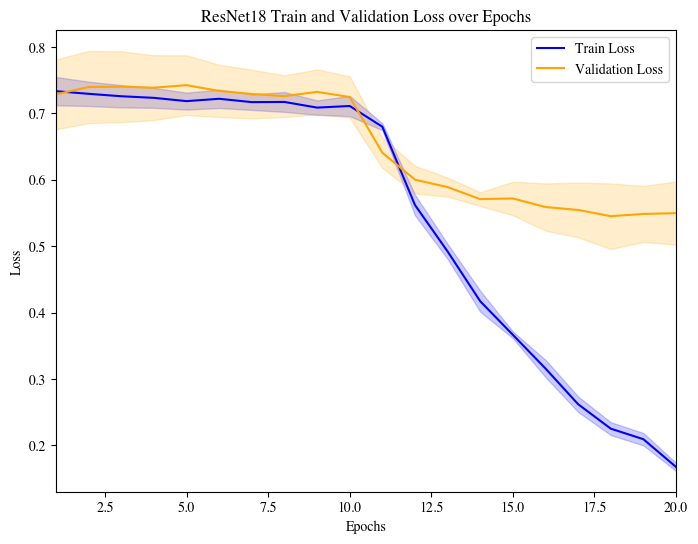

In [69]:
# plot average loss across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_loss_list, axis=0)
std_values = np.std(train_loss_list, axis=0)

plt.plot(epochs, mean_values, label='Train Loss', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(val_loss_list, axis=0)
std_values = np.std(val_loss_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Loss', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
# plt.ylim(0, 1.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet18 Train and Validation Loss over Epochs')
plt.legend()
plt.savefig('plots/resnet18/loss.png', dpi=300)


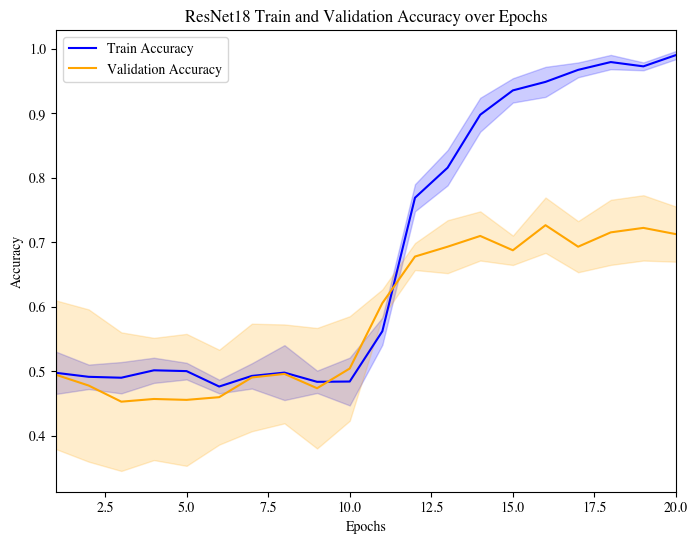

In [70]:
# plot average accuracy across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_acc_list, axis=0)
std_values = np.std(train_acc_list, axis=0)

plt.plot(epochs, mean_values, label='Train Accuracy', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

mean_values = np.mean(val_acc_list, axis=0)
std_values = np.std(val_acc_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Accuracy', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet18 Train and Validation Accuracy over Epochs')
plt.legend()
plt.savefig('plots/resnet18/accuracy.png', dpi=300)


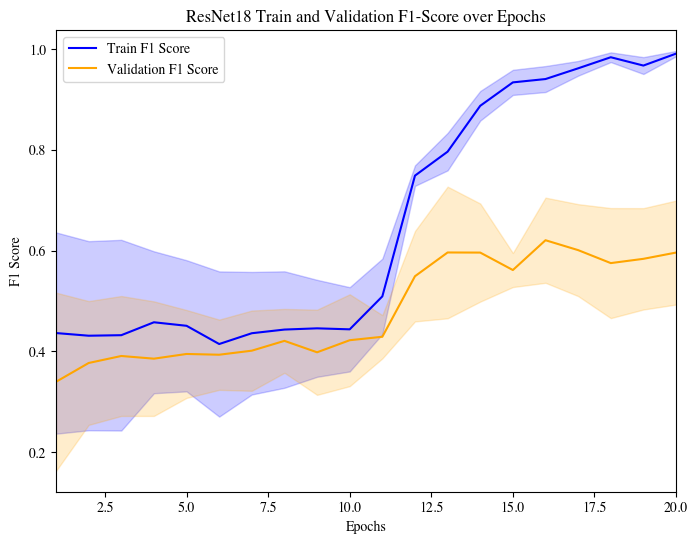

In [71]:
# plot average accuracy across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_f1_list, axis=0)
std_values = np.std(train_f1_list, axis=0)

plt.plot(epochs, mean_values, label='Train F1 Score', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

mean_values = np.mean(val_f1_list, axis=0)
std_values = np.std(val_f1_list, axis=0)

plt.plot(epochs, mean_values, label='Validation F1 Score', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('ResNet18 Train and Validation F1-Score over Epochs')
plt.legend()
plt.savefig('plots/resnet18/f1_score.png', dpi=300)


In [72]:
test_loss_list = []
test_acc_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_auc_list = []

# test resnet18
test_resnet('resnet18')

Fold: 1 Test Acc: 0.6623, Test Precision: 0.6462, Test Recall: 0.5750, Test F1: 0.6000
--------------------------------------------------
Fold: 2 Test Acc: 0.6587, Test Precision: 0.8182, Test Recall: 0.4000, Test F1: 0.5192
--------------------------------------------------
Fold: 3 Test Acc: 0.7238, Test Precision: 0.7208, Test Recall: 0.6761, Test F1: 0.6970
--------------------------------------------------
Fold: 4 Test Acc: 0.6569, Test Precision: 0.6182, Test Recall: 0.6312, Test F1: 0.6237
--------------------------------------------------
Fold: 5 Test Acc: 0.7081, Test Precision: 0.6894, Test Recall: 0.6071, Test F1: 0.6455
--------------------------------------------------


<Figure size 640x480 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


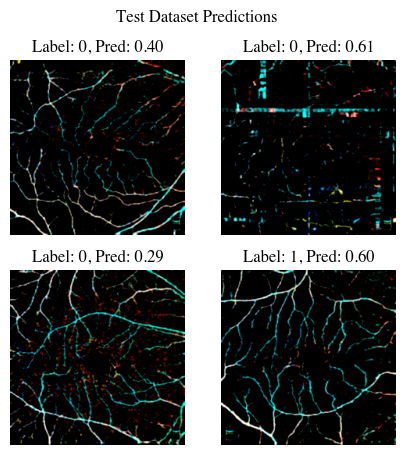

In [73]:
# show some images and predictions
test_loader = DataLoader(torch.utils.data.Subset(dataset, folds[0][1]), batch_size=4, shuffle=True)
model = ResNet('resnet18')
model.load_state_dict(torch.load(f'resnet18_1.pt'))

dataiter = iter(test_loader)
img, label = next(dataiter)
img = img.to(device)
label = label.to(device)
output = model(img)

fig = plt.figure(figsize=(5, 5))
for i in range(4):
	ax = fig.add_subplot(2, 2, i+1)
	ax.imshow(img[i].permute(1, 2, 0).cpu().numpy())
	ax.set_axis_off()
	ax.set_title(f'Label: {label[i].cpu().numpy()}, Pred: {(output[i].cpu().detach().numpy())[0]:.2f}')

# add title
plt.suptitle('Test Dataset Predictions')
# save image
plt.savefig('plots/resnet18/predictions.png', dpi=300)

In [74]:
# calculate average metrics for all folds
print('Average Test Accuracy: ', np.mean(test_acc_list), np.std(test_acc_list))
print('Average Test Precision: ', np.mean(test_precision_list), np.std(test_precision_list))
print('Average Test Recall: ', np.mean(test_recall_list), np.std(test_recall_list))
print('Average Test F1: ', np.mean(test_f1_list), np.std(test_f1_list))
print('Average Test AUC: ', np.mean(test_auc_list), np.std(test_auc_list))


Average Test Accuracy:  0.6819326923076923 0.028254368803936777
Average Test Precision:  0.6985381285381285 0.0694177851933248
Average Test Recall:  0.5779058441558441 0.09487736312061232
Average Test F1:  0.6170682660023473 0.058478449321543675
Average Test AUC:  0.6691581656097785 0.030811548894451663


In [55]:
# calculate average metrics for all folds print in latex format
print('&${0:.2f}\pm{1:.2f}$'.format(np.mean(test_acc_list), np.std(test_acc_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_precision_list), np.std(test_precision_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_recall_list), np.std(test_recall_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_f1_list), np.std(test_f1_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_auc_list), np.std(test_auc_list)))

&$0.70\pm0.04$ &$0.76\pm0.08$ &$0.56\pm0.16$ &$0.62\pm0.08$ &$0.68\pm0.04$


### Train ResNet50

In [56]:
train_loss_list = []
train_acc_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []

val_loss_list = []
val_acc_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []

# train resnet18
warmup_epochs = 6
fine_tune_epochs = 12
train_resnet('resnet50', warmup_epochs=warmup_epochs, fine_tune_epochs=fine_tune_epochs, lr=1e-5, batch_size=8)

Epoch: 1
			Train Loss: 0.7043, Train Acc: 0.4697, Train Precision: 0.4633, Train Recall: 0.7938, Train F1: 0.5740
			Val Loss: 0.7056, Val Acc: 0.3681, Val Precision: 0.2083, Val Recall: 0.3250, Val F1: 0.2282

Epoch: 2
			Train Loss: 0.7061, Train Acc: 0.4736, Train Precision: 0.4665, Train Recall: 0.7275, Train F1: 0.5522
			Val Loss: 0.6897, Val Acc: 0.5069, Val Precision: 0.3111, Val Recall: 0.6000, Val F1: 0.3611

Epoch: 3
			Train Loss: 0.7003, Train Acc: 0.4821, Train Precision: 0.4855, Train Recall: 0.5826, Train F1: 0.5036
			Val Loss: 0.6791, Val Acc: 0.5486, Val Precision: 0.4250, Val Recall: 0.5833, Val F1: 0.4615

Epoch: 4
			Train Loss: 0.6958, Train Acc: 0.4767, Train Precision: 0.4761, Train Recall: 0.5551, Train F1: 0.4961
			Val Loss: 0.6798, Val Acc: 0.5556, Val Precision: 0.4139, Val Recall: 0.5778, Val F1: 0.4807

Epoch: 5
			Train Loss: 0.6940, Train Acc: 0.4984, Train Precision: 0.4964, Train Recall: 0.5225, Train F1: 0.4948
			Val Loss: 0.6771, Val Acc: 0.5694,

In [57]:
num_epochs = warmup_epochs + fine_tune_epochs

train_loss_list = np.array(train_loss_list).reshape(5, num_epochs)
train_acc_list = np.array(train_acc_list).reshape(5, num_epochs)
train_precision_list = np.array(train_precision_list).reshape(5, num_epochs)
train_recall_list = np.array(train_recall_list).reshape(5, num_epochs)
train_f1_list = np.array(train_f1_list).reshape(5, num_epochs)

val_loss_list = np.array(val_loss_list).reshape(5, num_epochs)
val_acc_list = np.array(val_acc_list).reshape(5, num_epochs)
val_precision_list = np.array(val_precision_list).reshape(5, num_epochs)
val_recall_list = np.array(val_recall_list).reshape(5, num_epochs)
val_f1_list = np.array(val_f1_list).reshape(5, num_epochs)

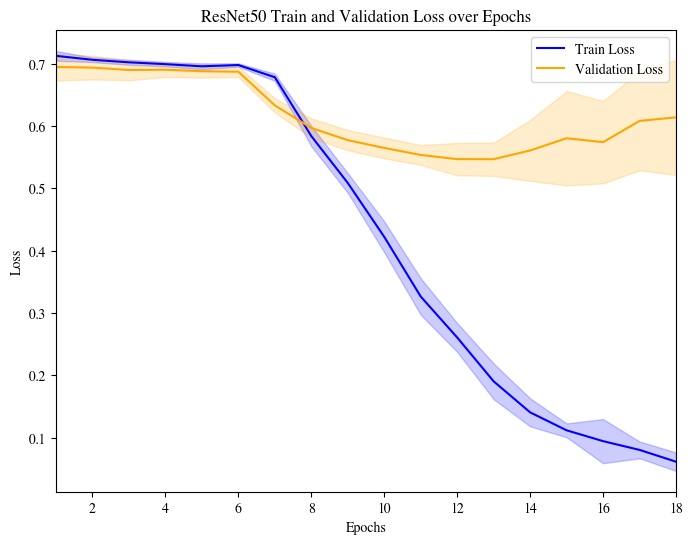

In [58]:
# plot average loss across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_loss_list, axis=0)
std_values = np.std(train_loss_list, axis=0)

plt.plot(epochs, mean_values, label='Train Loss', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(val_loss_list, axis=0)
std_values = np.std(val_loss_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Loss', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
# plt.ylim(0, 1.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet50 Train and Validation Loss over Epochs')
plt.legend()
plt.savefig('plots/resnet50/loss.png', dpi=300)

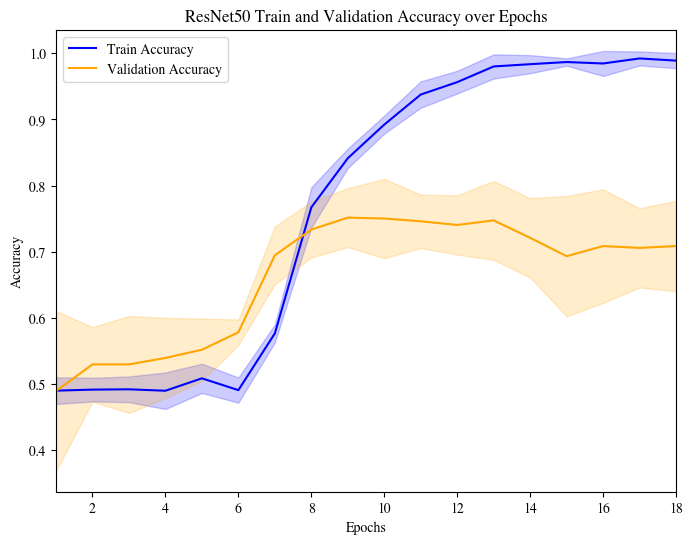

In [59]:
# plot average accuracy across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_acc_list, axis=0)
std_values = np.std(train_acc_list, axis=0)

plt.plot(epochs, mean_values, label='Train Accuracy', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

mean_values = np.mean(val_acc_list, axis=0)
std_values = np.std(val_acc_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Accuracy', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50 Train and Validation Accuracy over Epochs')
plt.legend()
plt.savefig('plots/resnet50/accuracy.png', dpi=300)


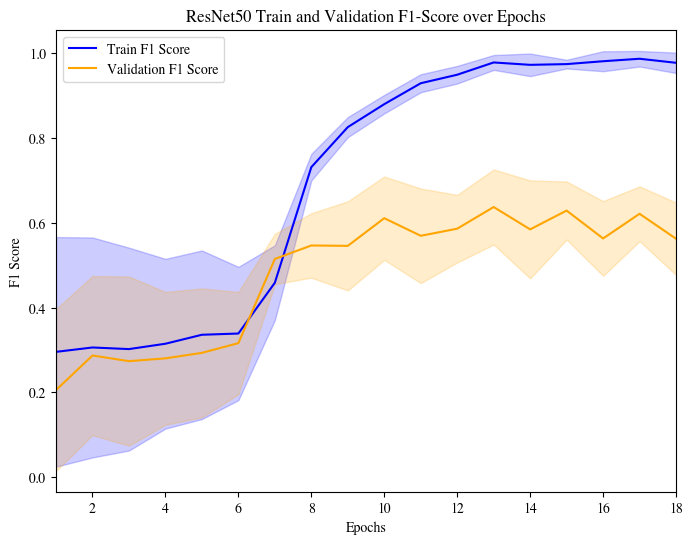

In [60]:
# plot average accuracy across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_f1_list, axis=0)
std_values = np.std(train_f1_list, axis=0)

plt.plot(epochs, mean_values, label='Train F1 Score', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

mean_values = np.mean(val_f1_list, axis=0)
std_values = np.std(val_f1_list, axis=0)

plt.plot(epochs, mean_values, label='Validation F1 Score', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('ResNet50 Train and Validation F1-Score over Epochs')
plt.legend()
plt.savefig('plots/resnet50/f1_score.png', dpi=300)


In [61]:
test_loss_list = []
test_acc_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_auc_list = []

# test resnet50
test_resnet('resnet50')

Fold: 1 Test Acc: 0.6238, Test Precision: 0.5994, Test Recall: 0.5682, Test F1: 0.5802
--------------------------------------------------
Fold: 2 Test Acc: 0.6238, Test Precision: 0.6250, Test Recall: 0.4833, Test F1: 0.5450
--------------------------------------------------
Fold: 3 Test Acc: 0.6438, Test Precision: 0.7232, Test Recall: 0.4006, Test F1: 0.5139
--------------------------------------------------
Fold: 4 Test Acc: 0.6550, Test Precision: 0.5754, Test Recall: 0.5563, Test F1: 0.5588
--------------------------------------------------
Fold: 5 Test Acc: 0.7194, Test Precision: 0.8167, Test Recall: 0.4939, Test F1: 0.6141
--------------------------------------------------


<Figure size 640x480 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


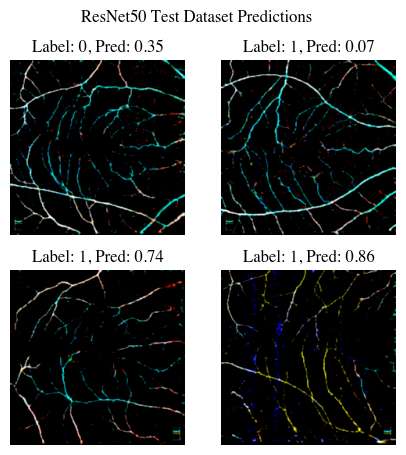

In [62]:
# show some images and predictions
test_loader = DataLoader(torch.utils.data.Subset(dataset, folds[0][1]), batch_size=4, shuffle=True)
model = ResNet('resnet50')
model.load_state_dict(torch.load(f'resnet50_1.pt'))

dataiter = iter(test_loader)
img, label = next(dataiter)
img = img.to(device)
label = label.to(device)
output = model(img)

fig = plt.figure(figsize=(5, 5))
for i in range(4):
	ax = fig.add_subplot(2, 2, i+1)
	ax.imshow(img[i].permute(1, 2, 0).cpu().numpy())
	ax.set_axis_off()
	ax.set_title(f'Label: {label[i].cpu().numpy()}, Pred: {(output[i].cpu().detach().numpy())[0]:.2f}')

# add title
plt.suptitle('ResNet50 Test Dataset Predictions')
# save image
plt.savefig('plots/resnet50/predictions.png', dpi=300)

In [63]:
# calculate average metrics for all folds
print('Average Test Accuracy: ', np.mean(test_acc_list), np.std(test_acc_list))
print('Average Test Precision: ', np.mean(test_precision_list), np.std(test_precision_list))
print('Average Test Recall: ', np.mean(test_recall_list), np.std(test_recall_list))
print('Average Test F1: ', np.mean(test_f1_list), np.std(test_f1_list))
print('Average Test AUC: ', np.mean(test_auc_list), np.std(test_auc_list))


Average Test Accuracy:  0.6531442307692308 0.03521534817436029
Average Test Precision:  0.6679273504273503 0.089762249395336
Average Test Recall:  0.5004545454545454 0.06002163770386317
Average Test F1:  0.5624027010770993 0.03365028297204712
Average Test AUC:  0.6458753791011855 0.03314581438077064


In [64]:
# calculate average metrics for all folds print in latex format
print('&${0:.2f}\pm{1:.2f}$'.format(np.mean(test_acc_list), np.std(test_acc_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_precision_list), np.std(test_precision_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_recall_list), np.std(test_recall_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_f1_list), np.std(test_f1_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_auc_list), np.std(test_auc_list)))

&$0.65\pm0.04$ &$0.67\pm0.09$ &$0.50\pm0.06$ &$0.56\pm0.03$ &$0.65\pm0.03$
